# Basic Dead Reckoning

In [7]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import time
from dataclasses import dataclass
import os
import random
import matplotlib.pyplot as plt

In [8]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray

#ground truth (x,y) points
def get_waypoints(data):
    gt_ts = data.waypoint[:,0]
    gt_x = data.waypoint[:,1]
    gt_y = data.waypoint[:,2]

    return gt_ts, gt_x, gt_y


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_ROTATION_VECTOR':
            if not(len(line_data) >= 5):
                print( f"Data from {data_filename} is bad")
            else:    
                ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])

        elif line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)

        elif line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)

        elif line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [17]:
MIN_STEP_TIME = 0.4
MA_WINDOW = 10

# Constants for step length model
STEP_A = 0.371
STEP_B = 0.227
STEP_C = 1
STEP_H = 1.65 #Height of person


# extract Z accelerometer data and find peaks as "steps"
def get_steps(data, maw=MA_WINDOW):
    
    #assuming phone is flat, no need for accex and accey
    acc_ts = (data.acce[:,0]) / 1000

    freq = np.median(np.diff(acc_ts))
    dist = np.round(MIN_STEP_TIME / freq)

    accz = data.acce[:,3]
    g = np.mean(accz)
    
    accz = accz - g
    acczma = moving_average(accz, maw)
    peaks, _ = find_peaks(acczma, distance=dist)

    return acc_ts, peaks

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Heading from rotation vector (TYPE_ROTATION_VECTOR)
def get_heading(data):

    rot_ts = (data.ahrs[:,0]) / 1000

    # Android sometimes missing quaternion norm
    a = np.linalg.norm(data.ahrs[: ,1:], axis=-1)
    b = data.ahrs[:,1]
    c = data.ahrs[:,2]
    d = data.ahrs[:,3]


    # Heading from quaternion
    num = 2 * ((b * c) + (a * d))
    dom = 1 - 2 * ( b**2 +  d**2)
    heading = np.arctan2(num, dom)

    return rot_ts, heading


# Returns list of headings at peak times
def get_stepheading(heading, heading_times, peaks, peak_times):
    
    np.testing.assert_array_almost_equal(heading_times, peak_times)
    step_heading = heading[peaks]
    step_times = peak_times[peaks]
    return step_times, step_heading

# Step length estimate
def steplength(peaks_f, time):
    step_freq = np.mean((1 / np.diff(time[peaks_f]))) # Step frequency as an average from dataset 

    step_length = (0.7 + STEP_A * (STEP_H-1.75) + STEP_B * (step_freq - 1.79) * STEP_H / 1.75) * STEP_C
    
    return step_length

# Start at some initial state and then track where each step takes you
def dead_reckoning(step_heading, step_length, start_x=0, start_y=0):
    x_coords = [start_x]
    y_coords = [start_y]
    corr_heading = step_heading + (0.5 * np.pi)

    for curr_head in corr_heading:
        curr_x = x_coords[-1]
        curr_y = y_coords[-1]
        x_coords = np.append(x_coords, curr_x + step_length * np.cos(curr_head))
        y_coords = np.append(y_coords, curr_y + step_length * np.sin(curr_head))
        
    return x_coords, y_coords

# Returns all control inputs for motion model for a given data file

def pedometer(data):
    # Get step times from accelerometer z data
    peak_times, peaks = get_steps(data)

    # Get heading from rotation vector data
    head_time, headings = get_heading(data)

    # Get heading at times when steps are detected
    step_times, step_heading = get_stepheading(headings, head_time, peaks, peak_times)
    
    # Use model to estimate step length
    step_length = steplength(peaks, peak_times)

    return step_heading, step_times, step_length

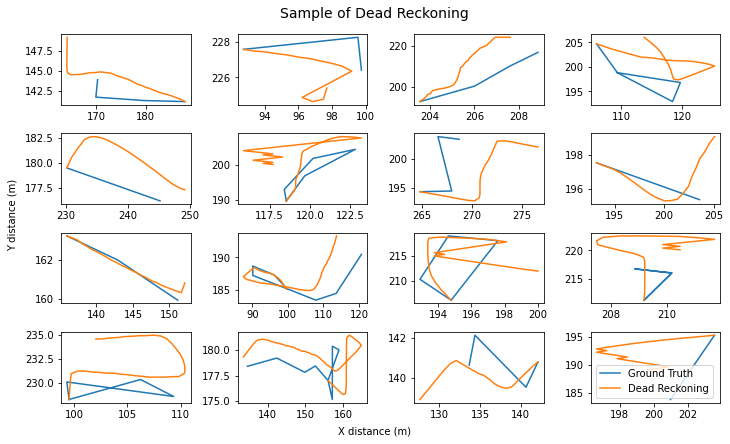

In [52]:
nrow = 4
ncol = 4

#sample data from https://github.com/location-competition/indoor-location-competition-20
directory = '.\data'

fig, axes = plt.subplots(nrow, ncol)
plt.rcParams['figure.figsize'] = [10, 6]

#random sample of data in folder
fname = []
for filename in random.sample(os.listdir(directory), ncol * nrow):
    if filename.endswith('txt'):
        fname = np.append(fname, os.path.join(directory, filename))
    else:
        continue

#plot all data in subfolders
l = 0
for i in range(nrow):
    for j in range(ncol):
        data = read_data_file(fname[l])
        gt_ts, gt_x, gt_y = get_waypoints(data)
        step_heading, step_times, step_length = pedometer(data)
        x_coords, y_coords = dead_reckoning(step_heading, step_length, gt_x[0], gt_y[0])
        axes[i][j].plot(gt_x, gt_y)
        axes[i][j].plot(x_coords, y_coords)
        l += 1
        
fig.suptitle("Sample of Dead Reckoning", fontsize=14)
fig.text(0.5, -0.01, 'X distance (m)', ha='center')
fig.text(-0.01, 0.5, 'Y distance (m)', va='center', rotation='vertical')
plt.legend(["Ground Truth", "Dead Reckoning"])
plt.tight_layout()
plt.savefig('basicdeadreckoning.png')